# Tutorial - Wasserstein GAN

In [306]:
using Flux
using Statistics, Distributions
using Plots

Suponha que observamos os dados acima e desconhecemos a função que os geraram.
O que queremos então fazer é criar uma rede neural que gera dados
dessa distribuição, onde temos acesso somente a essas amostras.

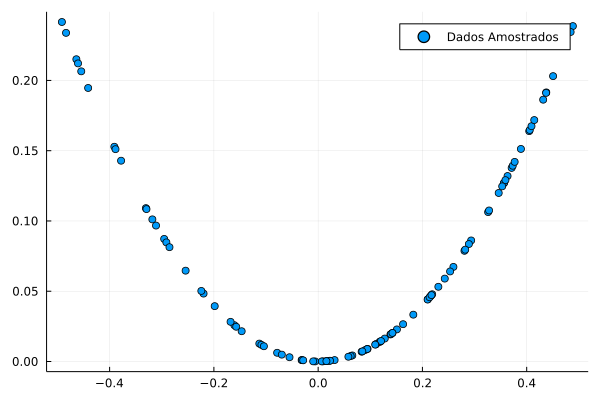

In [307]:
function generate_real_data(n)
    x1 = rand(1,n) .- 0.5
    x2 = x1 .* x1
    return vcat(x1,x2)
end

dados = generate_real_data(100)
x,y = dados[1,:], dados[2,:]
scatter(x,y, label="Dados Amostrados")

### Construindo o Discriminador e o Gerador

In [815]:
function D()
    return Chain(
            Dense(2, 25,relu),
            Dense(25,1)
            )
end

function G(latent_dim::Int)
    return Chain(
            Dense(latent_dim, 15,relu),
            Dense(15,2)
            )
end;


A WGAN busca resolver o seguinte problema de otimização:

$$
\min_{G} W_1(P_{\text{data}},P_g) = \min_{G}
\max_{D \in Lip_1}\mathbb E_{P_{\text{data}}}[D(x)]
-\mathbb E_{P_{g}}[D(x)]
$$

Assim, temos as seguintes funções de perda:

In [816]:
function wasserstein_loss_discr(real,fake, dscr)
    return -mean(dscr(real)) + mean(dscr(fake))
end

function wasserstein_loss_gen(z,gen,dscr)
    return -mean(dscr(gen(z)))
end


wasserstein_loss_gen (generic function with 2 methods)

#### Vamos descrever a função para treinar a rede $D$.

In [1021]:
function trainDiscriminator!(dscr,gen,train_size)
    ps = Flux.params(dscr)
    clip = 0.01
    m = round(Int,train_size)
    for n  in 1:10
        real = generate_real_data(m)
        fake = gen(rand(5,m))
        gs = gradient(Flux.params(dscr)) do
            l = wasserstein_loss_discr(real,fake,dscr)
        end
        Flux.update!(opt, ps, gs)
        for i in ps
            i = clamp.(i, -clip, clip)
        end
    end
end


function trainGenerator!(gen,dscr,train_size)
    noise = rand(5,train_size)
    data = Flux.Data.DataLoader(noise, batchsize=1,shuffle=true);
    for d in data
        gs = gradient(Flux.params(gen)) do
            l = wasserstein_loss_gen(d,gen,dscr)
        end
        Flux.update!(opt, Flux.params(gen), gs)
    end
    fake_generated = gen(rand(5,train_size))
end

trainGenerator! (generic function with 1 method)

In [1022]:
gen  = G(5)
dscr = D()
opt  = ADAM()
train_size = 1000

1000

In [1023]:
epochs = 1000
for e in 1:epochs
    trainDiscriminator!(dscr,gen,train_size)
    trainGenerator!(gen,dscr,train_size)
    if e%100 == 0
        real = generate_real_data(train_size)
        fake = gen(rand(5,train_size))
        @show mean(dscr(real)),mean(dscr(fake))
    end
end

(mean(dscr(real)), mean(dscr(fake))) = (0.03814053220113524, 0.06747331517689299)
(mean(dscr(real)), mean(dscr(fake))) = (0.05231588190657834, 0.07789927433535024)
(mean(dscr(real)), mean(dscr(fake))) = (0.07770658598628437, 0.0793662616652116)
(mean(dscr(real)), mean(dscr(fake))) = (0.07800559350951848, 0.08435798354780355)
(mean(dscr(real)), mean(dscr(fake))) = (0.10291185791808626, 0.10225903229283904)
(mean(dscr(real)), mean(dscr(fake))) = (0.09449738148433798, 0.1004520886154912)
(mean(dscr(real)), mean(dscr(fake))) = (0.09793333421448348, 0.0947445737906253)
(mean(dscr(real)), mean(dscr(fake))) = (0.12243641413270563, 0.12285954425495213)
(mean(dscr(real)), mean(dscr(fake))) = (0.11793136678182863, 0.09927151552574032)
(mean(dscr(real)), mean(dscr(fake))) = (0.11742659976211357, 0.09546434815066293)


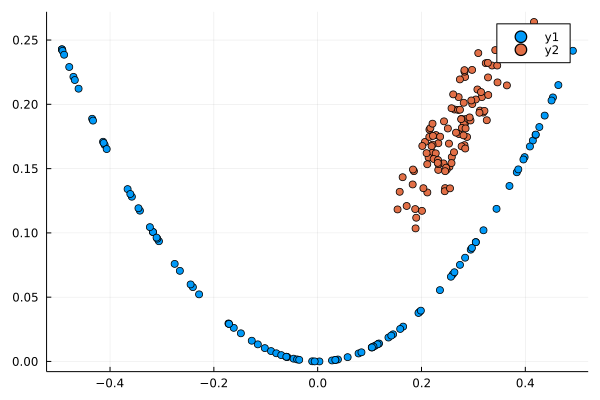

In [1024]:
train_size=100
real = generate_real_data(train_size)
fake = gen(rand(5,train_size))
scatter(real[1,1:train_size],real[2,1:train_size])
scatter!(fake[1,1:train_size],fake[2,1:train_size])